### Machine Learning Exercise - Spam filter 

Table of contents 
    1. Load the data & import tools 
    2. Helper functions 
        Stratified Triple Cross Validation 
        Custom Scoring Function 
    3. Naive Bayes 
        Helper functions
        'Manual' grid search 
        Plot results 
        Find best alpha
            'manually'
            w/ RandomizedSearchCV
        Test it on the test set 
    4. SVM 
        Helper functions 
        Experiment 1 
        Experiment 2 
        Experiment 3 
        Experiment 4 
        Experiment 5
        Precision / Recall curve of results
    5. Random Forests 
        Helper functions 
        Experiment 1 
        Experiment 2 
        Experiment 3 
        Experiment 4 
        Experiment 5
        Precision / Recall curve of results



### 1. Load the data

    The data has already been pre-processed to a bag of words representation, with a word count vector for each email.
    Stored in a sparse matrix, with 10.000 emails (data rows) and 57173 words (features).
    
    The following cell gets the data into a variable we can work with: 

In [10]:
from time import time
import os
import scipy.io
import numpy as np
import scipy.sparse as sp
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from inspect import signature
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score 


def get_data(name ):
    """
    :param name: name of .mat file in working directory
    :return:
        measurements are the bag of words representation of the emails
        labels are the corresponding labels
    """
    mat = scipy.io.loadmat(name)
    measurements = mat['X']
    labels = mat['Y']
    print(measurements.shape)
    print(labels.shape)

    return measurements, labels[0]

os.chdir("/Users/valdimareggertsson/Documents/Valdi/Sumarönn 2019/Machine Learning/Projects/")

m,l = get_data("emails.mat")
m_t = m.transpose()
# m is 10000 x 57173,   emails by words sparse matrix
    # data x features, meikar meira sense
# l is 1 x 1000 ,  labels by email
N = m.shape[1]
# N is number of emails

# m_t only has the counts. 
# Let's get a matrix with term frequencies weighted by inverse document frequency:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True, norm='l2')
tfidf_transformer.fit(m_t)
tfidf_m_t = tfidf_transformer.transform(m_t)

(57173, 10000)
(1, 10000)


### 2. Functions used
    i) conf_interpretation, which gets precision/accuracy/FPR/TPR from confusion matrix
    ii) cvkfold, which does k-fold stratified cross validation and splits the data set into train/validate/test
    iii) train_avg_cv, which trains a model using k-fold cross validation 

In [14]:
def conf_interpretation(con):
    """
    con is the output of metrics.confusion_matrix()
    """
    tp = con[1][1]
    fn = con[1][0]
    fp = con[0][1]
    tn = con[0][0]
    precision = tp / (tp+fp)
    r_fp = fp / (fp+tn)
    # false positive rate / false alarm rate
    # which must be max 0.002
    
    recall = tp / (tp + fn)
    
    accuracy = (tp + tn) / (tp+tn+fn+fp)
  
    return precision, accuracy, r_fp, recall 


def cvkfold(data, l, k):
    """
    data: matrix of measurements
    l: vector of labels 
    k: number of splits 
    returns: 
        a list of length k X_train/X_validate cross-validation pairs 
        X_test, y_test - a reserved test set containing 1/k of the rows from 'data'
        all stratified, i.e. with original class ratios
    """
    kf = StratifiedKFold(n_splits = k)

    i = 0 
    for train_index, test_index in kf.split(data, l):

        if i == 0:
            # reserve for testing 
            X_test = data[test_index]
            y_test = l[test_index]
        # hvað er í gangi hérna
        # ach ja, test tekið frá og restin notuð í train/validate 
            X = data[train_index]
            y = l[train_index]


    X_train, y_train = [], []
    X_validate, y_validate = [],[] 
    # X og y eru hráefni fyrir train/validation split 
    for tr, te in kf.split(X,y):
        X_train.append(data[tr])
        y_train.append(l[tr])

        X_validate.append(data[te])
        y_validate.append(l[te])    

    return X_train, y_train, X_validate, y_validate, X_test, y_test


def train_avg_cv(model, data,k):
    """
    Use: p, a = train_avg_cv(model,data)
    Before:  
        'model' is a classifier, 
        'data' is the matrix of measurements 
        'k' is the number of splits for CV 
    After: 
        p is the average precision found through k-fold cross validation
        a is the average accuracy found through k-fold cross validation
        cons is a list of confusion matrices for the splits 
    """
    
    X_train, y_train, X_validate, y_validate, X_test, y_test = cvkfold(data,l,k)
    avg_r_fp = 0 
    avg_r_tp = 0 
    avg_precision = 0 
    avg_accuracy = 0 
    cons = []
    for i in range(k):
        model.fit(X_train[i], y_train[i])
        pred = model.predict(X_validate[i])
        con = confusion_matrix(y_validate[i],pred)
        avg_precision += 1/k*conf_interpretation(con)[0]
        avg_accuracy += 1/k*conf_interpretation(con)[1]
        avg_r_fp += 1/k*conf_interpretation(con)[2]
        avg_r_tp += 1/k*conf_interpretation(con)[3]
        cons.append(con)
        print(con)

    return avg_precision, avg_accuracy, avg_r_fp, avg_r_tp


def show_best(random_results):
    """ 
    random_results is the outcome of RandomizedSearchCV()
    """
    best_prediction = random_results.best_estimator_.predict(X_test)
    con = confusion_matrix(y_test, best_prediction)
    print(conf_interpretation(con))
    print(con)
    print(random_results.best_estimator_)
    

### 3. Naive Bayes

The typical method for solving this task.

Functions: 
    - param_range,  which makes a list of hyperparameters (alpha) to check 
    - good_NB_classifiers,  which filters out only those hyperparameters that fulfil certain criteria 
    

In [ ]:
def param_range(start, end, rate):
    """
    returns: range(start,end,dx) distributed unevenly
    """
    parameters = []
    a = start 
    while(a < end):
        a += a/rate
        parameters.append(a)
    return parameters


def good_NB_classifiers(params_to_check, min_precision, min_accuracy, min_rfp, data,k):
    """
    Use: alphas_OK = good_NB_classifiers(params_to_check, min_precision)
    Before: 
        params_to_check is a list of hyperparameter values for NB
        min_precision, min_accuracy and min_rfp are requirements for precision/accuracy/false positive rate
        data is the matrix of measurements 
    After: 
        alphas_OK is a list of (precision, accuracy, FP rate, TP rate, parameter value) after k-fold CV with NB
    """

    params_OK = []
    for param in params_to_check:
        p,a,rfp,rtp = train_avg_cv(MultinomialNB(param), data,k)
        if p > min_precision and a > min_accuracy and rfp < min_rfp :
            params_OK.append((p,a, rfp, rtp, param))
        # a has the max precision
    return params_OK

In [ ]:
# Try a range of parameters and find adequate models
from sklearn.naive_bayes import MultinomialNB

min_precision = 0.999#0.999
min_accuracy = 0.993
max_rfp = 0.002

params_to_check = param_range(5e-08,7e-05, 4) #[0.000001, 0.0001,0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0]      
alphas_OK = good_NB_classifiers(params_to_check, min_precision, min_accuracy, max_rfp, m_t,20)
print("Good enough, without IDF:")
print(alphas_OK)

params_to_check = param_range(5e-8,1, 4) #[0.000001, 0.0001,0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0]      

wide_range_NB = good_NB_classifiers(params_to_check, 0.95, 0.90, 0.01, m_t,20)

## Plot the results that were found

In [ ]:
import matplotlib.pyplot as plt


def plotpics(results):
    """
    Before: 
        results is output from good_NB_classifiers
    After: 
        precision/recall, ROC and accuracy/precision/alpha curves have been displayed
    """
    alphas = [x[4] for x in results]
    precisions = [x[0] for x in results]
    accuracies = [x[1] for x in results]

    plt.plot(alphas,precisions, 'bo')
    plt.plot(alphas, accuracies,'ro')
    plt.legend(["Precision","Accuracy"])
    plt.xlabel("smoothing parameter alpha")
    plt.xticks([min(alphas), (min(alphas) + max(alphas))/2, max(alphas)])
    plt.show()

    fp_rate = [x[2] for x in results] 
    tp_rate = [x[3] for x in results]

    ### Plot ROC
    plt.plot(fp_rate, tp_rate)
    plt.title("ROC")
    plt.xlim(0,0.003)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

    ### Plot Precision/Recall curve
    plt.plot(tp_rate, precisions, "bo")
    plt.xlim(0.95,1)
    plt.ylim(0.9,1)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

    
plotpics(alphas_OK_IDF)
plotpics(wide_range_NB)

# Tiny alphas:
params_to_check = param_range(5e-4,1, 4)#[0.000001, 0.0001,0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0]      
alphas_tiny = good_NB_classifiers(params_to_check, min_precision, min_accuracy, max_rfp, m_t,20)

plotpics(alphas_tiny[:10])


### Find best alpha

In [ ]:
def minFar_sortAcc(a_OK):
    
    alphas = [x[4] for x in a_OK]
    precisions = [x[0] for x in a_OK]
    accuracies = [x[1] for x in a_OK]   
    fp_rate = [x[2] for x in a_OK] 
    tp_rate = [x[3] for x in a_OK]
    
    best = [x for x in a_OK if x[2] == np.max(fp_rate) and x[1] == np.max(accuracies)]

    # Choose the highest alpha
    best_alpha = np.max([x[4] for x in best])
    
    return best_alpha
    
    
best_alpha = minFar_sortAcc(alphas_OK)
            
best_alpha

## Evaluate the best alpha found on the test set 

In [ ]:
### Make a training set with 80% of the data
import scipy.sparse as sp

X_train, y_train, X_validate, y_validate, X_test, y_test = cvkfold(m_t,l,5)

big_train_X = sp.csr_matrix(np.concatenate((X_validate[0].toarray(),X_train[0].toarray()),axis=0))
big_train_y = np.concatenate((y_validate[0],y_train[0]))

In [ ]:
best_nb = MultinomialNB(best_alpha)

best_nb.fit(big_train_X, big_train_y)
prediction = best_nb.predict(X_test)
con = confusion_matrix(y_test,prediction)

print(con)

print(metrics.classification_report(y_test,prediction))
print(conf_interpretation(con))

print(train_avg_cv(best_nb,m_t,59))

### Grid search for alpha from sklearn with custom scoring function

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

params_to_check = param_range(5e-8,7e-3, 4)
random_grid = {'alpha': params_to_check}
nb_random = RandomizedSearchCV(estimator = MultinomialNB(), param_distributions = random_grid, 
                                   scoring = scorer, n_iter = 10, cv = 5, random_state = 42, n_jobs = -1)
nb_random.fit(big_train_X, big_train_y)
show_best(nb_random)

## Make ROC curve for NB

In [ ]:
from sklearn.metrics import roc_curve, auc

model = nb_random.best_estimator_

model.fit(big_train_X, big_train_y)

y_score = model.predict_proba(X_test)[:,1]

fpr, tpr, _ =roc_curve(y_test, y_score)
roc_auc = auc(fpr,tpr)
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) 
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example') 
plt.legend(loc="lower right")

### Make precision-recall curve for NB

In [ ]:
from sklearn.metrics import precision_recall_curve
from inspect import signature
from sklearn.metrics import average_precision_score 

average_precision = average_precision_score(y_test, y_score)
precision, recall, _ =precision_recall_curve(y_test, y_score)
step_kwargs = ({'step': 'post'}
if 'step' in signature(plt.fill_between).parameters
else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

## 4. Support Vector Machines

### Pre-processing and helper functions

- Scale the data to variance 1 
- train_avg_cv_fast(), function which does k-fold cross validation and stops if any of the splits have high FPR or low accuracy
- good_SVM_classifiers(), function which filters out only models with good parameters


In [ ]:
# Sklearn wants the data scaled.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean = False)
scaler.fit(m_t)
m_t_s = scaler.transform(m_t)


### To speed up the training. If the results of the first split give over 1% FPR, then stop training this model.
def train_avg_cv_fast(model, data,k):
    """
    Use: p, a = train_avg_cv(model,data)
    Before:  
        'model' is a classifier, 
        'data' is the matrix of measurements 
        'k' is the number of splits for CV 
    After: 
        p is the average precision found through k-fold cross validation
        a is the average accuracy found through k-fold cross validation
        cons is a list of confusion matrices for the splits 
        
        Returns 0,0,0,0 if it seems hopeless 
    """
    
    X_train, y_train, X_validate, y_validate, X_test, y_test = cvkfold(data,l,k)
    avg_r_fp = 0 
    avg_r_tp = 0 
    avg_precision = 0 
    avg_accuracy = 0 
    cons = []
    for i in range(k):
        model.fit(X_train[i], y_train[i])
        pred = model.predict(X_validate[i])
        con = confusion_matrix(y_validate[i],pred)
        
        avg_precision += 1/k*conf_interpretation(con)[0]
        avg_accuracy += 1/k*conf_interpretation(con)[1]
        avg_r_fp += 1/k*conf_interpretation(con)[2]
        avg_r_tp += 1/k*conf_interpretation(con)[3]
        
        if(conf_interpretation(con)[2] > 0.01  or conf_interpretation(con)[1] < 0.96):
            print("Too many false positives or too low accuracy ")
            return 0,0,0,0
        
        cons.append(con)
        print(con)


    return avg_precision, avg_accuracy, avg_r_fp, avg_r_tp

def good_SVM_classifiers(kernel, weights,cs, data, max_fpr, min_acc):
    """
    Use: 
        goodies =  good_SVM_classifiers(kernel, weights,cs, data)
    Before: 
        kernel is a SVM kernel
        weights is a list of weights for class_weight
        cs is a list of paramters C 
        data is the dataset to be trained on 
        max_fpr is the maximum false positive rate which is good enough 
        min_acc is the minimum accuracy which is good enough 
    After: 
        goodies is the list of parameters/results that have are good enough
    """
    good_cs = []
    good_weights = []
    good_results = []
    results = []
    for weight_dict in [{1:1, -1:x} for x in weights]:
    
        for c in cs:
            results.append(train_avg_cv_fast(SVC(C = c, kernel = kernel, class_weight = weight_dict, max_iter = 1000), data,5))
            if results[-1][2] < max_fpr  and results[-1][1] > min_acc:
                # vista bara það sem er með <0.2% FPR 
                print("woohoo")
                print("weight:")
                print(weight_dict[-1])
                print("C:")
                print(c)
                good_cs.append(c)
                good_weights.append(weight_dict[-1])
                good_results.append(results[-1])
            
    return (kernel, good_weights, good_cs, good_results)    

### Experiment 1

Try out different kernels and some C and class_weights.

In [ ]:
from time import time
all_good = {}

max_fpr = 0.002
min_acc = 0.975

cs = [0.5,1.5,5]
weights = [3,5,7,10,100]

for kernel in ['linear', 'rbf', 'sigmoid', 'poly']:
    t0 = time()

    all_good[kernel] = good_SVM_classifiers(kernel, weights, cies, m_t_s, max_fpr, min_acc)
    print(" done in %0.3fs" % (time() - t0)) 

# all_good is a dict with the good classifiers for the 4 kernels and the weights tested 

### Experiment 2

Search further around the models that were good.


In [ ]:
all_good

### Try the good results that were found on the test set

##### SVM parameters that look good,
    Sigmoid: 
    weight -1 =  (5,7)
    with C = 0.5 

Let's try out values around those values.  Search with 10.000 iterations even?

cs =  [0.4,... , 0.7] with 0.05 in between
weights = [4... 9] með 0.5 in between 


In [ ]:
c = 0.5
for weight_dict in  [{1:1, -1:5}, {1:1, -1:7}]:
    model = SVC(C = c, kernel = 'sigmoid', class_weight = weight_dict, max_iter = 1000)
    model.fit(big_train_X, big_train_y)
    prediction = model.predict(X_test)
    con = confusion_matrix(y_test,prediction)

    print(con)
    print(metrics.classification_report(y_test,prediction))
    print(conf_interpretation(con))

### Turns out the nice results didn't generalise to the test set!

Let's anyway search around them for something better

In [ ]:
cs = param_range(0.3,2,15)
weights = param_range(4,9,7)
goodies = good_SVM_classifiers('sigmoid', weights, cs, m_t_s, max_fpr, min_acc)

print(goodies)

### Found a few good results:


- weights_found = [4.571, 5.224, 5.970, 5.970, 6.824, 6.824]
- c_found = [0.536, 0.503,0.536, 0.503, 0.536, 0.503, 0.536]

How good is the best one? Let's try'em out on the test set.

In [ ]:
weights_found = [4.571, 5.224, 5.970, 5.970, 6.824, 6.824]
c_found = [0.536, 0.503,0.536, 0.503, 0.536, 0.503, 0.536]

round2_goodvals = []
good_mdls = []
for i,w in enumerate(weights_found):
    print(i)
    modl = SVC(C = c_found[i], kernel = "sigmoid", class_weight = {1:1,-1:w}, max_iter = 1000)
    round2_goodvals.append(train_avg_cv(modl, m_t_s,5))
    good_mdls.append(modl)
    
# Test good models on test set:
for model in good_mdls:
    model.fit(big_train_X, big_train_y)
    prediction = model.predict(X_test)
    con = confusion_matrix(y_test,prediction)

    print(str(i) + "\n")
    print(con)

    print(metrics.classification_report(y_test,prediction))
    print(conf_interpretation(con))

### Experiment 3

Search a wider range of parameters.

In [ ]:

dc = 0.2
staerd = dc
cies = []
for i in range(10):

    cies.append(staerd)
    if i % 9 == 0 and i >0:
        #print(cies)
        dc*=10
    staerd = staerd+dc
weights = [1,3,5,7,9,10,15,20,25,30,40,60,80,100]

# cies is a list of values of C     
# weights is a list for class_weights

all_good3 = {}

for kernel in ['linear', 'rbf', 'sigmoid', 'poly']:
    t0 = time()

    all_good3[kernel] = good_SVM_classifiers(kernel, weights, cies, m_t_s, max_fpr, min_acc)
    print(" done in %0.3fs" % (time() - t0)) 
## all_good3 is a dict with the good classifiers for the 4 kernels and the weights tested 

### Good results:

In [ ]:
all_good3

### Experiment 4
Bigger search, also for gamma.
Try to have the data both scaled and not scaled.
Keep te weights that have proved successful.

In [ ]:
g = 1
gammas =['auto']
for i in range(10):        
    g/=10
    gammas.append(g)

all_good4 = {}

kernel = 'sigmoid'
min_acc = 0.96
weights = [1,5]

for data in [m_t_s,m_t]:
    all_good4[kernel] = good_SVM_classifiers(kernel, weights, cies, data, max_fpr, min_acc)

## No good results printing out after many hours?

shouldn't have tried to have it unscaled?

### Experiment 5 - RandomizedSearchCV()

enough of this manual labour - let's try the in-built method that I discovered too late

In [ ]:
# Make parameters to try

dc = 0.2
staerd = dc
cies = []
for i in range(10):
    cies.append(staerd)
    if i % 9 == 0 and i >0:
        dc*=10
    staerd = staerd+dc

g = 1
gammas =['auto']
for i in range(10):        
    g/=10
    gammas.append(g)
 
weights = [1,3,5,7,9,10,15,20,25,30,40,60,80,100]

# Make grid of parameters to check:
svm_grid = {'C': cies, 'class_weight': [{1:1, -1:x} for x in weights], 'gamma': gammas}
svm_grid

In [ ]:
from sklearn.svm import SVC
svm_random = RandomizedSearchCV(estimator = SVC(kernel = 'sigmoid', max_iter = 1000), param_distributions=svm_grid, 
                                scoring = scorer, n_iter = 500, cv = 5, random_state = 42, n_jobs = -1)
svm_random.fit(big_train_X, big_train_y)
show_best(svm_random)

#### Turns out it only found garbage??

### Precision / Recall curve for classifiers found in CV

Text(0, 0.5, 'Precision')

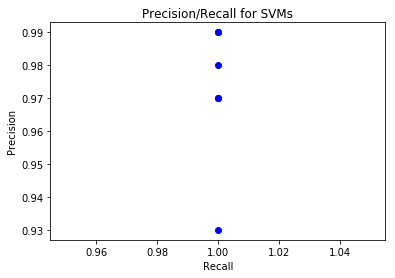

In [25]:
precisions = [1, 1,1,1,1,1]
recalls = [0.99, 0.97, 0.99, 0.98, .97,0.93]

plt.plot(precisions, recalls, 'bo')
plt.title("Precision/Recall for SVMs")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

## 5. Random Forests

contents:
    - Helper functions 
    - Experiment 1 
    - Experiment 2 
    - Experiment 3 
    - Experiment 4 
    - Experiment 5

Helper functions 

In [6]:
from sklearn import metrics

def big_random_search(scorer, n_iterations, weights, max_depth=list(range(5,100,5)), n_estimators=list(range(5,200,5)), min_samples_split=[2,5,10], max_features=['sqrt', 'log2',100, 1000, 10000, 30000]):
    """
    Use: 
        ensemble = big_random_search(scorer, n_iterations, weights, max_depth, n_estimators, min_samples_split, max_features):
    Before: 
        scorer is a scorer from sklearn.metrics, made from a scoring/loss function
            or a string which is valid as argument 'scoring' to RandomizedSearchCV
        n_iterations controls how long the random search is 
        rest of arguments are parameters for the random forest 
    After: 
        ensemble is a random forest found through RandomizedSearchCV given the parameters 
    """
    bootstrap  = [True, False]
    class_weights = [{1:1,-1:x} for x in weights]
    min_samples_leaf = [1,2,5,10]

    random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': 
                   max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 
                   'bootstrap': bootstrap, 'class_weight': class_weights}

    rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = random_grid, 
                                   scoring = scorer, n_iter = n_iterations, cv = 5, random_state = 42, n_jobs = -1)

    rf_random.fit(big_train_X, big_train_y)
    
    return rf_random

def my_score_function(y_true, y_predict):
    """
    Use: 
        score = my_score_function(y_true,y_predict)
    Before:
        y_true are true labels, y_predict predicted labels 
    After: 
        score is an evaluation of how good the prediction was
        (only good if the fpr was adequate and recall is good)
    """
    con = confusion_matrix(y_true,y_predict)
    precision, accuracy, fpr, recall = conf_interpretation(con)
    if fpr <= 1/500:
        score =5* recall
    else:
        score = 0
        
    return score 

scorer = metrics.make_scorer(my_score_function)

### Check the baseline model

In [29]:
# baseline:
clf = RandomForestClassifier()
clf.get_params()
#print(train_avg_cv(clf,m_t,10))

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### Experiment 1

    - Find optimal precision 
    
    - Display results 

    - Search further around the result for models that were good.


In [ ]:
n_estimators = list(range(5,200,5))
max_features = ['sqrt', 'log2',100, 1000, 10000, 30000]
max_depth = list(range(5,100,5))
min_samples_split = [2,5,10]
weights = [0.1, 0.2, 0.5, 1,3,5,7,9,15,20]

rf_precision = big_random_search('precision', 20, weights, max_depth, n_estimators, min_samples_split, max_features)

show_best(rf_precision)

Good parameters found: 
    weight = 5
    max_depth = 65 
    n_estimators = 25 

In [ ]:
# Further search for high recall around the one found 

rf_no_fn_hi_recall = big_random_search(metrics.make_scorer(my_score_function), 50, [3,5,7,9], [55,60,65,70], [20,25,30])

show_best(rf_no_fn_hi_recall)

### Experiment 2

    - Find optimal recall 
    
    - Display results 

    - Search further around the result for models that were good.


In [ ]:
weights = [0.1, 0.2, 0.5, 1,3,5,7,9,15,20]
rf_recall = big_random_search(scorer, 20, weights)
show_best(rf_recall)

### Experiment 3

    - Find optimal accuracy 
    
    - Display results 

    - a) Search further around the result for models that were good.
    
    - b) Adjust the probability threshold needed to classify as spam


In [ ]:
weights = [0.1, 0.2, 0.5, 1,3,5,7,9,15,20]
rf_roc_auc = big_random_search('roc_auc', 20, weights)
show_best(rf_roc_auc)

#### 3 a)  Search around the high accuracy results

In [ ]:
# high accuracy parameters:
weight = 1
max_depth = 80
max_features = 1000 
min_samples_leaf = 2 
min_samples_split = 2 
n_estimators = 45 


rf_hi_acc = big_random_search(scorer, 80, [0.5,1,2,5], [70,75,80,85,90], [40,45,50,55,60], [2,3], [800,1000, 1200])
show_best(rf_hi_acc)

#### 3 b) Find the probability threshold needed to classify as spam without false positives

In [ ]:
clf = rf_hi_acc.best_estimator_
predicted_spam_p = clf.predict_proba(X_test)[:,1]

def adjusted_classes(spam_probabilities,t):
    return [1 if y >= t else 0 for y in spam_probabilities]

threshold = 0.5
for i in range(50):
    print(threshold + i/100)
    print(confusion_matrix(y_test, adjusted_classes(predicted_spam_p, threshold + i/100)))
    print("\n")

Raising the threshold of probability decreases FP at the cost of some FN. 
raising it to 52% for the classifier found removes the single FP from the classifier

### Experiment 4       -   search randomly over a big grid and see if something pops up 

In [ ]:
rf_custom_score_big_search = big_random_search(scorer, 300, [0.1, 0.2, 0.5, 1,3,5,7,9,15,20,30])
show_best(rf_custom_score_big_search)

### Experiment 5  -  do exhaustive search over relatively big grid 

Try combinations of the parameters whose models were fairly good. 

In [ ]:
# With the custom scorer

class_weight = (1,3,5, 7, 15)
max_depth = (50,55, 60, 65, 70, 75,85)
min_samples_split = (2,5,10)   
max_features = (100, 1000,'sqrt')
min_samples_leaf = (1,5)
n_estimators = (20,40, 80,120)  
Bootstrap = False 
class_weights = [{1: x} for x in class_weight]


random_grid = {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 
               'bootstrap': bootstrap, 'class_weight': class_weights}

rf_exhaustive = GridSearchCV(estimator = RandomForestClassifier(), param_grid = random_grid, scoring=scorer,cv = 5,  n_jobs = -1)
rf_exhaustive.fit(big_train_X, big_train_y)
show_best(rf_exhaustive)

In [ ]:
# With the default scorer

class_weight = (1,3,5, 7, 15)
max_depth = (50,55, 60, 65, 70, 75,85)
min_samples_split = (2,5,10)   
max_features = (100, 1000,'sqrt')
min_samples_leaf = (1,5)
n_estimators = (20,40, 80,120)  
Bootstrap = False 
class_weights = [{1: x} for x in class_weight]


random_grid = {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 
               'bootstrap': bootstrap, 'class_weight': class_weights}

rf_exhaustive2 = GridSearchCV(estimator = RandomForestClassifier(), param_grid = random_grid, scoring=None,cv = 5,  n_jobs = -1)
rf_exhaustive2.fit(big_train_X, big_train_y)
show_best(rf_exhaustive2)

## Experiment 6 

Try out training with TF-IDF

In [5]:
### Make a training set with 80% of the data, tfidf 
import scipy.sparse as sp

X_train, y_train, X_validate, y_validate, X_test, y_test = cvkfold(tfidf_m_t,l,5)

big_train_X = sp.csr_matrix(np.concatenate((X_validate[0].toarray(),X_train[0].toarray()),axis=0))
big_train_y = np.concatenate((y_validate[0],y_train[0]))

In [27]:
def big_random_search(scorer, n_iterations, weights, max_depth=list(range(5,100,5)), n_estimators=list(range(5,200,5)), min_samples_split=[2,5,10], max_features=['sqrt', 'log2',100, 1000, 10000, 30000]):
    """
    Use: 
        ensemble = big_random_search(scorer, n_iterations, weights, max_depth, n_estimators, min_samples_split, max_features):
    Before: 
        scorer is a scorer from sklearn.metrics, made from a scoring/loss function
            or a string which is valid as argument 'scoring' to RandomizedSearchCV
        n_iterations controls how long the random search is 
        rest of arguments are parameters for the random forest 
    After: 
        ensemble is a random forest found through RandomizedSearchCV given the parameters 
    """
    bootstrap  = [True, False]
    class_weights = [{1:1,-1:x} for x in weights]
    min_samples_leaf = [1,2,5,10]

    random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': 
                   max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 
                   'bootstrap': bootstrap, 'class_weight': class_weights}

    rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = random_grid, 
                                   scoring = scorer, n_iter = n_iterations, cv = 5, random_state = 42, n_jobs = -1)

    rf_random.fit(big_train_X, big_train_y)
    
    return rf_random

n_estimators = list(range(5,200,5))
max_features = ['sqrt', 'log2',100, 1000, 10000, 30000]
max_depth = list(range(5,100,5))
min_samples_split = [2,5,10]
weights = [0.1, 0.2, 0.5, 1,3,5,7,9,15,20]

rf_custom_idf = big_random_search(scorer, 300, weights, max_depth, n_estimators, min_samples_split, max_features)

show_best(rf_custom_idf)

### Precision/Recall for good classifiers 

Text(0, 0.5, 'Precision')

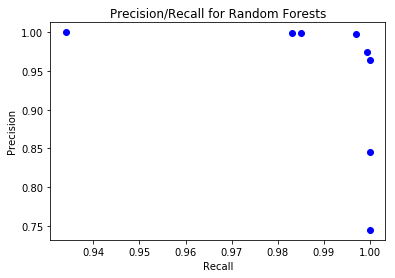

In [23]:
precisions = [0.985, 1,  1,  0.934,             1,  0.983 ,                1 - 1/1567,  1 - 5/1607]
recalls = [0.999, 1-410/1606, 1 - 249/1606, 1,   1 - 57/1606, 1 - 2/1604, 1 - 40/1606,   1 - 4/1602 ]

plt.plot(precisions, recalls, 'bo')
plt.title("Precision/Recall for Random Forests")
plt.xlabel("Recall")
plt.ylabel("Precision")

In [ ]:
# ROC fyrir RF 
model = RandomForestClassifier(bootstrap=False, class_weight={1: 1, -1: 1},
            criterion='gini', max_depth=85, max_features=1000,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=145, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)


model.fit(big_train_X, big_train_y)

y_score = model.predict_proba(X_test)[:,1]

fpr, tpr, _ =roc_curve(y_test, y_score)
roc_auc = auc(fpr,tpr)
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) 
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example') 
plt.legend(loc="lower right")